# Estimate Optimal Solution Interval for Self-Calibration

In [1]:
import numpy as np
import casatools
import casatasks

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

## Get Total On-Source Time

In [2]:
ms = "/rds/user/pmk46/hpc-work/19A-056/pipeline/nbooks/QSO-J0818+1722-mod.ms"

tb = casatools.table()
tb.open(ms)
time_array = tb.getcol("TIME")
exposure = np.nanmean(tb.getcol("EXPOSURE"))
tb.close()

ttot = max(time_array) - min(time_array) + exposure

print("Total On-Source Time: ", ttot, " s")
print("Exposure Time: ", exposure, " s")

Total On-Source Time:  626.0  s
Exposure Time:  2.0  s


## Gain Calibration on Infinite Solution Interval to Solve for Polarisation Offset

In [3]:
# calibrate polarisation offset
casatasks.gaincal(
  ms,
  caltable="selfcal-Ginf.tb",
  solint="inf",
  refant="ea19",
  calmode="p",
  solnorm=True,
  solmode="R", 
  gaintype="G", 
  combine="spw",
)

2023-11-08 09:39:59	SEVERE	MeasTable::dUTC(Double) (file casacore/measures/Measures/MeasTable.cc, line 4290)	Leap second table TAI_UTC seems out-of-date.
2023-11-08 09:39:59	SEVERE	MeasTable::dUTC(Double) (file casacore/measures/Measures/MeasTable.cc, line 4290)+	Until the table is updated (see the CASA documentation or your system admin),
2023-11-08 09:39:59	SEVERE	MeasTable::dUTC(Double) (file casacore/measures/Measures/MeasTable.cc, line 4290)+	times and coordinates derived from UTC could be wrong by 1s or more.


{'apply_tables': array([], dtype='<U5'),
 'selectvis': {'antennas': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
  'field': array([0]),
  'intents': array(['CALIBRATE_AMPLI#UNSPECIFIED', 'CALIBRATE_BANDPASS#UNSPECIFIED',
         'CALIBRATE_FLUX#UNSPECIFIED', 'CALIBRATE_PHASE#UNSPECIFIED',
         'OBSERVE_TARGET#UNSPECIFIED', 'SYSTEM_CONFIGURATION#UNSPECIFIED'],
        dtype='<U32'),
  'observation': array([0]),
  'scan': array([6]),
  'spw': array([0, 1, 2, 3, 4, 5, 6, 7, 8])},
 'solve_tables': array(['selfcal-Ginf.tb'], dtype='<U15'),
 'solvestats': {'above_minblperant': array([1, 1]),
  'above_minsnr': array([1, 1]),
  'data_unflagged': array([1, 1]),
  'expected': array([1, 1]),
  'spw0': {'above_minblperant': array([1, 1]),
   'above_minsnr': array([1, 1]),
   'ant0': {'above_minblperant': array([1, 1]),
    'above_minsnr': array([1, 1]),
    'data_unflagged': array([1, 1]),
    'expected': array([

## Short Interval Gain Calibrations

In [4]:
solint0 = ttot / (ttot // 2)

# calibrate polarisation offset
casatasks.gaincal(
  ms,
  caltable="selfcal-Gshort.tb",
  solint=f"{solint0}s",
  refant="ea19", 
  calmode="p", 
  solnorm=True,
  solmode="R", 
  gaintype="G", 
  combine="spw",
  gaintable="selfcal-Ginf.tb",
  spwmap=[0,0,0,0,0,0,0,0,0],
)

Found no unflagged data at:   (time=2019/09/13/15:33:11.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:13.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:15.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:17.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:19.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:21.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:23.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:25.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:27.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:29.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:31.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:33.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019

{'apply_tables': array(['selfcal-Ginf.tb'], dtype='<U15'),
 'selectvis': {'antennas': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
  'field': array([0]),
  'intents': array(['CALIBRATE_AMPLI#UNSPECIFIED', 'CALIBRATE_BANDPASS#UNSPECIFIED',
         'CALIBRATE_FLUX#UNSPECIFIED', 'CALIBRATE_PHASE#UNSPECIFIED',
         'OBSERVE_TARGET#UNSPECIFIED', 'SYSTEM_CONFIGURATION#UNSPECIFIED'],
        dtype='<U32'),
  'observation': array([0]),
  'scan': array([6]),
  'spw': array([0, 1, 2, 3, 4, 5, 6, 7, 8])},
 'solve_tables': array(['selfcal-Gshort.tb'], dtype='<U17'),
 'solvestats': {'above_minblperant': array([284, 284]),
  'above_minsnr': array([284, 284]),
  'data_unflagged': array([284, 284]),
  'expected': array([313, 313]),
  'spw0': {'above_minblperant': array([284, 284]),
   'above_minsnr': array([284, 284]),
   'ant0': {'above_minblperant': array([284, 284]),
    'above_minsnr': array([284, 284]),
    'dat

In [5]:
solint1 = ttot / (ttot // 20)
           
# calibrate polarisation offset
casatasks.gaincal(
  ms,
  caltable="selfcal-Gshort-x10.tb",
  solint=f"{solint1}s",
  refant="ea19", 
  calmode="p", 
  solnorm=True,
  gaintype="G", 
  combine="spw",
  gaintable="selfcal-Ginf.tb",
  spwmap=[0,0,0,0,0,0,0,0,0],
)

Found no unflagged data at:   (time=2019/09/13/15:33:21.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/13/15:33:42.0 field=0 spw=0 chan=0)


{'apply_tables': array(['selfcal-Ginf.tb'], dtype='<U15'),
 'selectvis': {'antennas': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
  'field': array([0]),
  'intents': array(['CALIBRATE_AMPLI#UNSPECIFIED', 'CALIBRATE_BANDPASS#UNSPECIFIED',
         'CALIBRATE_FLUX#UNSPECIFIED', 'CALIBRATE_PHASE#UNSPECIFIED',
         'OBSERVE_TARGET#UNSPECIFIED', 'SYSTEM_CONFIGURATION#UNSPECIFIED'],
        dtype='<U32'),
  'observation': array([0]),
  'scan': array([6]),
  'spw': array([0, 1, 2, 3, 4, 5, 6, 7, 8])},
 'solve_tables': array(['selfcal-Gshort-x10.tb'], dtype='<U21'),
 'solvestats': {'above_minblperant': array([29, 29]),
  'above_minsnr': array([29, 29]),
  'data_unflagged': array([29, 29]),
  'expected': array([31, 31]),
  'spw0': {'above_minblperant': array([29, 29]),
   'above_minsnr': array([29, 29]),
   'ant0': {'above_minblperant': array([29, 29]),
    'above_minsnr': array([29, 29]),
    'data_unflagged'

## Extract Data from Short Interval Gain Solutions

In [6]:
nsolint = int(ttot // 2)

tb = casatools.table()
tb.open("selfcal-Gshort.tb")
  
ants = tb.getcol("ANTENNA1")
data, flags, time = [], [], []

for ant in np.unique(ants):
    t1 = tb.query(f"ANTENNA1=={ant}")
    data.append(t1.getcol("CPARAM"))
    flags.append(t1.getcol("FLAG"))
    time.append(t1.getcol("TIME"))     
    t1.close() 

data = np.ma.array(data, mask=flags)[:, :, 0].T 
time = np.mean(time, axis=0)

tb.close()

tb.open("selfcal-Gshort-x10.tb")
  
ants = tb.getcol("ANTENNA1")
data_x10, flags_x10, time_x10 = [], [], []

for ant in np.unique(ants):
    t1 = tb.query(f"ANTENNA1=={ant}")
    data_x10.append(t1.getcol("CPARAM"))
    flags_x10.append(t1.getcol("FLAG"))
    time_x10.append(t1.getcol("TIME"))     
    t1.close() 

data_x10 = np.ma.array(data_x10, mask=flags_x10)[:, :, 0].T 
time_x10 = np.mean(time_x10, axis=0)

tb.close()

True

## Average Gain Solutions in Time

In [7]:
def mad(data):
    return 1.4826 * np.nanmedian(np.abs(data - np.nanmedian(data.real) - 1j * np.nanmedian(data.imag)))

In [49]:
dt_list = []
varI_list, varN_list = [], []

# estimate nois by differencing polarisations
var0 = np.nanvar((data[:, 0] - data[:, 1]) / np.sqrt(2))

# alternatively estimate noise by time differencing
#var0 = np.nanvar((data[1:-2:2] - 0.5 * (data[0:-2:2]+data[2::2])) / np.sqrt(3/2))

nsolint = int(ttot // 2)

for nt in range(1, data.shape[0]):
    dt_list.append(data.shape[0] // nt)

dt_list = np.unique(dt_list)[:-1]
data_nt_list, time_nt_list = [], []

for n, dt in enumerate(dt_list):
    data_nt, time_nt = [], []
    nt = data.shape[0] // dt

    for i in range(nt):
        data_nt.append(np.exp(1j * np.angle(np.nanmean(data[i*dt:(i+1)*dt], axis=0))))
        time_nt.append(np.nanmean(time[i*dt:(i+1)*dt], axis=0))
    
    data_nt = np.array(data_nt)
    data_nt = interp1d(time_nt, data_nt, fill_value="extrapolate", kind="linear", axis=0)(time)[:, [0, 1]]
    data_nt_list.append(data_nt)
    time_nt_list.append(time_nt)
    vart = np.nanvar((data_nt[:, 0] - data_nt[:, 1]) / np.sqrt(2))
    covt = np.cov((data_nt[:, 0] - data_nt[:, 1]).reshape(-1) / np.sqrt(2), (data[:, 0] - data[:, 1]).reshape(-1) / np.sqrt(2))
    covt = np.real((covt[0, 1] + covt[1, 0]))
    #varI_list.append(np.nanvar(data - data_nt) - 1 * var0 * (dt - 1) / dt)
    varI_list.append(np.nanvar(data - data_nt) - var0 - vart + covt)
    #varI_list.append(np.nanvar(data - data_nt))
    varN_list.append(var0 * nt / nsolint / dt)

#var0 = varI_list[1] * 2
#varI_list = np.array(varI_list) - var0 * (dt_list - 1) / dt_list
#print(varI_list)


## Plot Gains vs Time

20.193548387096776 2.0


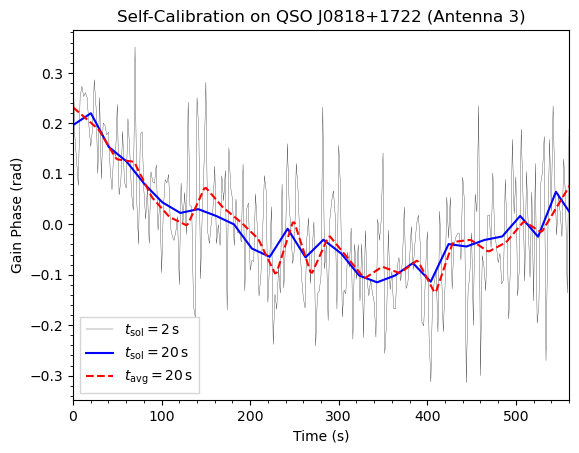

In [50]:
print(ttot / (ttot // 20), ttot / (ttot // 2))

t_array = np.arange(len(time_nt_list[0])) * ttot / (ttot // 2)
t_x10_array = np.arange(len(time_x10)) * ttot / (ttot // 20)

plt.plot(t_array, np.angle(data_nt_list[0][..., 1, 3]), label=r"$t_\mathrm{sol}=2\,$s", color="k", linewidth=0.2)
plt.plot(t_x10_array, np.angle(data_x10[..., 1, 3]), label=r"$t_\mathrm{sol}=20\,$s", color="b")
plt.plot(t_array, np.angle(data_nt_list[9][..., 1, 3]), label=r"$t_\mathrm{avg}=20\,$s", color="r", linestyle="--")

plt.title("Self-Calibration on QSO J0818+1722 (Antenna 3)")
plt.xlabel("Time (s)")
plt.ylabel("Gain Phase (rad)")

plt.xlim(0, 560)
plt.minorticks_on()
plt.legend(fancybox=False)


## Plot Estimated Variances as a Function of Self-Calibration Solution Interval

In [51]:
varI_list = np.array(varI_list)
varN_list = np.array(varN_list)
var_tot = varI_list + varN_list
imin = np.nanargmin(var_tot)
solint = solint0 * np.array(dt_list)[imin]

In [52]:
varI_list[varI_list<=0] = np.nan

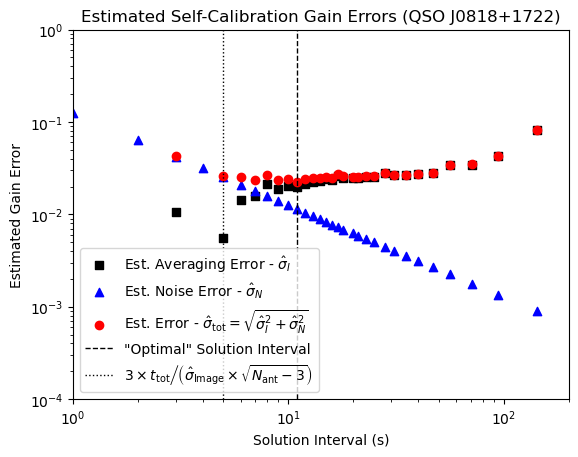

In [53]:

plt.scatter(dt_list, np.sqrt(varI_list), color="k", marker="s", label=r"Est. Averaging Error - $\hat{\sigma}_{I}$")
plt.scatter(dt_list, np.sqrt(varN_list), color="b", marker="^", label=r"Est. Noise Error - $\hat{\sigma}_{N}$")
plt.scatter(dt_list, np.sqrt(varI_list + varN_list), facecolors="r", marker="o", label=r"Est. Error - $\hat{\sigma}_\mathrm{tot} = \sqrt{\hat{\sigma}_{I}^2 + \hat{\sigma}_{N}^2}$")
plt.vlines(dt_list[imin], 1e-4, 1e0, color="k", linestyle="--", linewidth=1, label='"Optimal" Solution Interval')
plt.vlines(5, 1e-4, 1e0, color="k", linestyle="dotted", linewidth=1, label=r"$3 \times t_\mathrm{tot} \left/ \left(\hat{\sigma}_\mathrm{Image} \times \sqrt{N_\mathrm{ant}-3}\right)\right.$")

plt.title("Estimated Self-Calibration Gain Errors (QSO J0818+1722)")
plt.xlabel("Solution Interval (s)")
plt.ylabel("Estimated Gain Error")
plt.xscale("log")
plt.yscale("log")
        
plt.xlim(1e0, 2e2)
plt.ylim(1e-4, 1e-0)

plt.legend(loc=3)